<a href="https://colab.research.google.com/github/BardRimon/Study/blob/main/Reinforcement_Learning/HW2/HW2_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install flappy-bird-gymnasium torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [56]:
import os
from datetime import datetime, timedelta
import argparse
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

DATE_FORMAT = "%m-%d %H:%M:%S"

In [22]:
config_content = '''
{

    "version": "0.2.0",
    "configurations": [
        {
            "name": "Train cartpole1",
            "type": "debugpy",
            "request": "launch",
            "program": "agent.py",
            "console": "integratedTerminal",
            "args": ["cartpole1", "--train"]
        },
        {
            "name": "Train flappybird1",
            "type": "debugpy",
            "request": "launch",
            "program": "agent.py",
            "console": "integratedTerminal",
            "args": ["flappybird1", "--train"]
        }
    ]
}
'''
with open('launch.json', 'w') as file:
    file.write(config_content)

In [9]:
config_content = '''cartpole1:
  env_id: CartPole-v1
  replay_memory_size: 100000
  mini_batch_size: 32
  epsilon_init: 1
  epsilon_decay: 0.9995
  epsilon_min: 0.05
  network_sync_rate: 10
  learning_rate_a: 0.0001
  discount_factor_g: 0.99
  stop_on_reward: 100000
  fc1_nodes: 512
  env_make_params:
    use_lidar: False
  enable_double_dqn: True
  enable_dueling_dqn: True

flappybird1:
  env_id: FlappyBird-v0
  replay_memory_size: 100000
  mini_batch_size: 32
  epsilon_init: 1
  epsilon_decay: 0.99_99_5
  epsilon_min: 0.05
  network_sync_rate: 10
  learning_rate_a: 0.0001
  discount_factor_g: 0.99
  stop_on_reward: 100000
  fc1_nodes: 512
  env_make_params:
    use_lidar: False
  enable_double_dqn: True
  enable_dueling_dqn: True
'''

with open('hyperparameters.yml', 'w') as file:
    file.write(config_content)

In [32]:
import torch
from torch import nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=256, enable_dueling_dqn=True):
        super(DQN, self).__init__()

        self.enable_dueling_dqn=enable_dueling_dqn

        self.fc1 = nn.Linear(state_dim, hidden_dim)

        if self.enable_dueling_dqn:
            # Value stream
            self.fc_value = nn.Linear(hidden_dim, 256)
            self.value = nn.Linear(256, 1)

            # Advantages stream
            self.fc_advantages = nn.Linear(hidden_dim, 256)
            self.advantages = nn.Linear(256, action_dim)

        else:
            self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        if self.enable_dueling_dqn:
            # Value calc
            v = F.relu(self.fc_value(x))
            V = self.value(v)

            # Advantages calc
            a = F.relu(self.fc_advantages(x))
            A = self.advantages(a)

            # Calc Q
            Q = V + A - torch.mean(A, dim=1, keepdim=True)

        else:
            Q = self.output(x)

        return Q



state_dim = 12
action_dim = 2
net = DQN(state_dim, action_dim)
state = torch.randn(10, state_dim)
output = net(state)
print(output)


tensor([[ 2.1688e-02, -4.2941e-01],
        [-2.0843e-01, -3.2929e-01],
        [-1.3379e-01, -2.4609e-01],
        [-9.1848e-02, -2.1786e-01],
        [ 6.8156e-02, -4.6601e-01],
        [ 1.8730e-02, -3.6038e-01],
        [-1.1307e-04, -2.5051e-01],
        [-1.8811e-01, -2.2911e-01],
        [-1.1324e-01, -2.9127e-01],
        [-1.3768e-01, -4.9660e-01]], grad_fn=<SubBackward0>)


In [7]:
from collections import deque
import random

class ReplayMemory():
    def __init__(self, maxlen, seed=0):
        self.memory = deque([], maxlen=maxlen)

        if seed is not None:
            random.seed(seed)


    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [33]:
import gymnasium as gym
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import random
import torch
from torch import nn
import yaml



from datetime import datetime, timedelta
import argparse
import itertools

import flappy_bird_gymnasium
import os

# For printing date and time
DATE_FORMAT = "%m-%d %H:%M:%S"

# Directory for saving run info
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# 'Agg': used to generate plots as images and save them to a file instead of rendering to screen
matplotlib.use('Agg')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # force cpu, sometimes GPU not always faster than CPU due to overhead of moving data to GPU

# Deep Q-Learning Agent
class Agent():

    def __init__(self, hyperparameter_set):
        with open('hyperparameters.yml', 'r') as file:
            all_hyperparameter_sets = yaml.safe_load(file)
            hyperparameters = all_hyperparameter_sets[hyperparameter_set]
            # print(hyperparameters)

        self.hyperparameter_set = hyperparameter_set

        # Hyperparameters (adjustable)
        self.env_id             = hyperparameters['env_id']
        self.learning_rate_a    = hyperparameters['learning_rate_a']        # learning rate (alpha)
        self.discount_factor_g  = hyperparameters['discount_factor_g']      # discount rate (gamma)
        self.network_sync_rate  = hyperparameters['network_sync_rate']      # number of steps the agent takes before syncing the policy and target network
        self.replay_memory_size = hyperparameters['replay_memory_size']     # size of replay memory
        self.mini_batch_size    = hyperparameters['mini_batch_size']        # size of the training data set sampled from the replay memory
        self.epsilon_init       = hyperparameters['epsilon_init']           # 1 = 100% random actions
        self.epsilon_decay      = hyperparameters['epsilon_decay']          # epsilon decay rate
        self.epsilon_min        = hyperparameters['epsilon_min']            # minimum epsilon value
        self.stop_on_reward     = hyperparameters['stop_on_reward']         # stop training after reaching this number of rewards
        self.fc1_nodes          = hyperparameters['fc1_nodes']
        self.env_make_params    = hyperparameters.get('env_make_params',{}) # Get optional environment-specific parameters, default to empty dict
        self.enable_double_dqn  = hyperparameters['enable_double_dqn']      # double dqn on/off flag
        self.enable_dueling_dqn = hyperparameters['enable_dueling_dqn']     # dueling dqn on/off flag

        # Neural Network
        self.loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
        self.optimizer = None                # NN Optimizer. Initialize later.

        # Path to Run info
        self.LOG_FILE   = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.log')
        self.MODEL_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.pt')
        self.GRAPH_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.png')

    def run(self, is_training=True, render=False):
        if is_training:
            start_time = datetime.now()
            last_graph_update_time = start_time

            log_message = f"{start_time.strftime(DATE_FORMAT)}: Training starting..."
            print(log_message)
            with open(self.LOG_FILE, 'w') as file:
                file.write(log_message + '\n')

        # Create instance of the environment.
        # Use "**self.env_make_params" to pass in environment-specific parameters from hyperparameters.yml.
        env = gym.make(self.env_id, render_mode='human' if render else None, **self.env_make_params)

        # Number of possible actions
        num_actions = env.action_space.n

        # Get observation space size
        num_states = env.observation_space.shape[0] # Expecting type: Box(low, high, (shape0,), float64)

        # List to keep track of rewards collected per episode.
        rewards_per_episode = []

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)

        if is_training:
            # Initialize epsilon
            epsilon = self.epsilon_init

            # Initialize replay memory
            memory = ReplayMemory(self.replay_memory_size)

            # Create the target network and make it identical to the policy network
            target_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)
            target_dqn.load_state_dict(policy_dqn.state_dict())

            # Policy network optimizer. "Adam" optimizer can be swapped to something else.
            self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

            # List to keep track of epsilon decay
            epsilon_history = []

            # Track number of steps taken. Used for syncing policy => target network.
            step_count=0

            # Track best reward
            best_reward = -9999999
        else:
            # Load learned policy
            policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))

            # switch model to evaluation mode
            policy_dqn.eval()

        # Train INDEFINITELY, manually stop the run when you are satisfied (or unsatisfied) with the results
        for episode in itertools.count():

            state, _ = env.reset()  # Initialize environment. Reset returns (state,info).
            state = torch.tensor(state, dtype=torch.float, device=device) # Convert state to tensor directly on device

            terminated = False      # True when agent reaches goal or fails
            episode_reward = 0.0    # Used to accumulate rewards per episode

            # Perform actions until episode terminates or reaches max rewards
            # (on some envs, it is possible for the agent to train to a point where it NEVER terminates, so stop on reward is necessary)
            while(not terminated and episode_reward < self.stop_on_reward):

                # Select action based on epsilon-greedy
                if is_training and random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()
                    action = torch.tensor(action, dtype=torch.int64, device=device)
                else:
                    # select best action
                    with torch.no_grad():
                        # state.unsqueeze(dim=0): Pytorch expects a batch layer, so add batch dimension i.e. tensor([1, 2, 3]) unsqueezes to tensor([[1, 2, 3]])
                        # policy_dqn returns tensor([[1], [2], [3]]), so squeeze it to tensor([1, 2, 3]).
                        # argmax finds the index of the largest element.
                        action = policy_dqn(state.unsqueeze(dim=0)).squeeze().argmax()

                # Execute action. Truncated and info is not used.
                new_state,reward,terminated,truncated,info = env.step(action.item())

                # Accumulate rewards
                episode_reward += reward

                # Convert new state and reward to tensors on device
                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                reward = torch.tensor(reward, dtype=torch.float, device=device)

                if is_training:
                    # Save experience into memory
                    memory.append((state, action, new_state, reward, terminated))

                    # Increment step counter
                    step_count+=1

                # Move to the next state
                state = new_state

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(episode_reward)

            # Save model when new best reward is obtained.
            if is_training:
                if episode_reward > best_reward:
                    log_message = f"{datetime.now().strftime(DATE_FORMAT)}: New best reward {episode_reward:0.1f} ({(episode_reward-best_reward)/best_reward*100:+.1f}%) at episode {episode}, saving model..."
                    print(log_message)
                    with open(self.LOG_FILE, 'a') as file:
                        file.write(log_message + '\n')

                    torch.save(policy_dqn.state_dict(), self.MODEL_FILE)
                    best_reward = episode_reward


                # Update graph every x seconds
                current_time = datetime.now()
                if current_time - last_graph_update_time > timedelta(seconds=10):
                    self.save_graph(rewards_per_episode, epsilon_history)
                    last_graph_update_time = current_time

                # If enough experience has been collected
                if len(memory)>self.mini_batch_size:
                    mini_batch = memory.sample(self.mini_batch_size)
                    self.optimize(mini_batch, policy_dqn, target_dqn)

                    # Decay epsilon
                    epsilon = max(epsilon * self.epsilon_decay, self.epsilon_min)
                    epsilon_history.append(epsilon)

                    # Copy policy network to target network after a certain number of steps
                    if step_count > self.network_sync_rate:
                        target_dqn.load_state_dict(policy_dqn.state_dict())
                        step_count=0


    def save_graph(self, rewards_per_episode, epsilon_history):
        # Save plots
        fig = plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        mean_rewards = np.zeros(len(rewards_per_episode))
        for x in range(len(mean_rewards)):
            mean_rewards[x] = np.mean(rewards_per_episode[max(0, x-99):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        # plt.xlabel('Time Steps')
        plt.ylabel('Epsilon Decay')
        plt.plot(epsilon_history)

        plt.subplots_adjust(wspace=1.0, hspace=1.0)

        # Save plots
        fig.savefig(self.GRAPH_FILE)
        plt.close(fig)


    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Transpose the list of experiences and separate each element
        states, actions, new_states, rewards, terminations = zip(*mini_batch)

        # Stack tensors to create batch tensors
        # tensor([[1,2,3]])
        states = torch.stack(states)

        actions = torch.stack(actions)

        new_states = torch.stack(new_states)

        rewards = torch.stack(rewards)
        terminations = torch.tensor(terminations).float().to(device)

        with torch.no_grad():
            if self.enable_double_dqn:
                best_actions_from_policy = policy_dqn(new_states).argmax(dim=1)

                target_q = rewards + (1-terminations) * self.discount_factor_g * \
                                target_dqn(new_states).gather(dim=1, index=best_actions_from_policy.unsqueeze(dim=1)).squeeze()
            else:
                # Calculate target Q values (expected returns)
                target_q = rewards + (1-terminations) * self.discount_factor_g * target_dqn(new_states).max(dim=1)[0]
                '''
                    target_dqn(new_states)  ==> tensor([[1,2,3],[4,5,6]])
                        .max(dim=1)         ==> torch.return_types.max(values=tensor([3,6]), indices=tensor([3, 0, 0, 1]))
                            [0]             ==> tensor([3,6])
                '''

        # Calcuate Q values from current policy
        current_q = policy_dqn(states).gather(dim=1, index=actions.unsqueeze(dim=1)).squeeze()
        '''
            policy_dqn(states)  ==> tensor([[1,2,3],[4,5,6]])
                actions.unsqueeze(dim=1)
                .gather(1, actions.unsqueeze(dim=1))  ==>
                    .squeeze()                    ==>
        '''

        # Compute loss
        loss = self.loss_fn(current_q, target_q)

        # Optimize the model (backpropagation)
        self.optimizer.zero_grad()  # Clear gradients
        loss.backward()             # Compute gradients
        self.optimizer.step()       # Update network parameters i.e. weights and biases

# if __name__ == '__main__':
#     # Parse command line inputs
#     parser = argparse.ArgumentParser(description='Train or test model.')
#     parser.add_argument('hyperparameters', help='')
#     parser.add_argument('--train', help='Training mode', action='store_true')
#     args = parser.parse_args()

#     dql = Agent(hyperparameter_set=args.hyperparameters)

#     if args.train:
#         dql.run(is_training=True)
#     else:
#         dql.run(is_training=False, render=True)

dql = Agent(hyperparameter_set='flappybird1')

dql.run(is_training=True)

05-23 11:23:28: Training starting...
05-23 11:23:36: New best reward -5.7 (-100.0%) at episode 0, saving model...
05-23 11:23:36: New best reward -5.1 (-10.5%) at episode 31, saving model...
05-23 11:23:37: New best reward -4.5 (-11.8%) at episode 74, saving model...
05-23 11:23:38: New best reward -3.9 (-13.3%) at episode 124, saving model...
05-23 11:23:38: New best reward -3.3 (-15.4%) at episode 161, saving model...
05-23 11:23:46: New best reward -2.1 (-36.4%) at episode 634, saving model...


KeyboardInterrupt: 

In [55]:
!wget https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/runs/

--2025-05-23 12:56:33--  https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/runs/
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2025-05-23 12:56:33 ERROR 400: Bad Request.



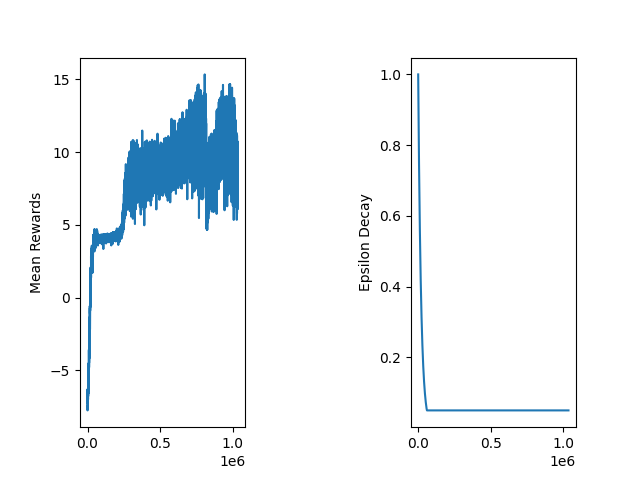

In [62]:
from IPython.display import display, Image
image_path = '/content/runs/flappybird1.png'
display(Image(filename=image_path))